In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sb
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from time import time
from collections import Counter, defaultdict
import nltk
from pprint import pprint
import copy

import seaborn as sns
from itertools import combinations


import pickle
from IPython.core.display import HTML

import pymongo
import pyLDAvis
%matplotlib inline

![](http://www.listchallenges.com/f/lists/d7aacdae-74bd-42ff-b397-b73905b5867b.jpg)

![](https://media.licdn.com/mpr/mpr/shrinknp_400_400/AAEAAQAAAAAAAASeAAAAJDA2YWEwZmFjLTg5MDgtNGE2OC04MTBhLTk3MzNiNGIxM2RkYQ.jpg)

### EDA - Presentation Version

This notebook is a cleaned up version of **EDA - Scrapy Version**. Here we refactor scrapy code in order to increase efficiency and readability in preperation for production, as well as provide ample explanations for methodoogy and results. 

## Introduction

**Machine learning (ML)** and **Natural Language Processing (NLP)** are technologies that are ubiquitous in startups because of their ability to structure, and extract analytics insights, from text data. ML and NLP can be used to build sentiment classification models, recommendation systems, and data-driven products. Here, we will leaverge ML and NLP to build a named entity search engine for New York Times (NYT) Articles. 

The goal of this work is to use unsurpervised ML to bring more structure to the articles using Topic Modeling, to identify and extract named entites from the articels using Entity Recognition, and finally to build an application that will help reveal relationships between named entites in the NYT corpus. 



#### Import Data

Here we import the NYT corpus from our database for unstructured data, MongoDB. The articles were [scraped](https://github.com/DataBeast03/DataBeast/blob/master/NYT_Articles/Srcape_NYT_Articles_2016.ipynb) from the NYT api and stored in [MongoDB](https://www.mongodb.com/). 

In [2]:
def get_data_from_mongodb(db_name, coll_name):
    '''Returns documents from specifed database and collections in mongodb
       Will try to return docs in pandas dataframe
       If that fails, it will return a pointer to the data in mongo'''

    # pull scraped articles out of mongodb 
    client = pymongo.MongoClient()
    db = client.get_database(name = db_name)
    pointer_to_mongo_data = db[coll_name].find()
    
    try:
        # move articles to pandas
        df = pd.DataFrame(list(pointer_to_mongo_data))
        print ("Successfull - returned a df")
    
        return df
    except: 
        print ("Unsuccessfull - did not return a df")
        return pointer_to_mongo_data

In [3]:
db_name = "nyt2016"
coll_name = "articles"
df = get_data_from_mongodb(db_name, coll_name)

Successfull - returned a df


#### Inspect Data

The pandas dataframe shows that there is a lot of [metadata](https://en.wikipedia.org/wiki/Metadata) surrounding the actual articles, including the section that the article is from. 

In [4]:
df.head(2)

,_id,abstract,blog,body,byline,document_type,headline,keywords,lead_paragraph,multimedia,...,print_page,pub_date,section_name,slideshow_credits,snippet,source,subsection_name,type_of_material,web_url,word_count
0,580ae247253f0a1d0316f71e,None,[],TOKYO — State-backed Japan Bank for Internati...,"{'person': [], 'original': 'By REUTERS', 'orga...",article,{'print_headline': 'Japan to Lend to Sanctione...,[],State-backed Japan Bank for International Coop...,[],...,None,2016-10-21T23:51:28Z,Business Day,None,State-backed Japan Bank for International Coop...,Reuters,None,News,http://www.nytimes.com/reuters/2016/10/21/busi...,None
1,580adf45253f0a1d0316f71d,None,[],"INTERNATIONAL\nBecause of an editing error, an...",[],article,"{'print_headline': 'Corrections', 'main': 'Cor...",[],"Corrections appearing in print on Saturday, Oc...",[],...,None,2016-10-21T23:38:36Z,Corrections,None,"Corrections appearing in print on Saturday, Oc...",The New York Times,None,News,http://www.nytimes.com/2016/10/22/pageoneplus/...,None


We can see that the article's publication dates range between October 5th to November 11th. These dates cover the 2nd and 3rd presidental debates as well as the election results. 

In [22]:
# range of publicatin dates of our articles 
df.pub_date.max(), df.pub_date.min()

('2016-11-27T23:54:23+0000', '2016-10-05T22:03:14Z')

The print out below shows how many articles belong to each section. The top 3 most populated sections are U.S., World, and Business in that order. For the purpose of this prototype, we'll be focusing on the articles belonging to the U.S. section. Though the exact analysis and productization can be performed for the other sections. Indeed, that is the ultimate goal. 

In [7]:
# count of how many articles are included in each section 
Counter(df.section_name)

Counter({'Arts': 1037,
         'Automobiles': 13,
         'Books': 180,
         'Briefing': 94,
         'Business Day': 3615,
         'Corrections': 35,
         'Crosswords & Games': 54,
         'Education': 17,
         'Fashion & Style': 348,
         'Food': 102,
         'Giving': 13,
         'Health': 56,
         'Job Market': 14,
         'Magazine': 76,
         'Movies': 157,
         'N.Y. / Region': 354,
         'NYT Now': 9,
         'Obituaries': 1,
         'Opinion': 727,
         'Podcasts': 17,
         'Public Editor': 8,
         'Real Estate': 90,
         'Science': 129,
         'Sports': 3719,
         'Style': 35,
         'Sunday Review': 3,
         'T Magazine': 82,
         'Technology': 416,
         'The Learning Network': 116,
         'The Upshot': 66,
         'Theater': 134,
         'Times Insider': 45,
         'Today’s Paper': 34,
         'Travel': 85,
         'U.S.': 6039,
         'Universal': 2,
         'Well': 92,
         'World': 5

In [9]:
# create masks that identify "US" articles from the sections
US_section_mask = df.section_name == "U.S."
US_corpus_df = df[US_section_mask]
US_corpus = US_corpus_df.body.values

This is a print of a typical NYT article in the U.S. section. This article is short in length; the length of each article varies. We can already make several observations regarding topic modeling and named entities. For instance, this article is about a police shooting and the justice system. 2016 was a year many publicized police shootings. So it is reasonable to expect that the justice system or something similar will be a topic. Several named entites also appear in this article. "Wisconsin" is an example of a location entity and the officer's name "Devon Kraemer" is an example of a person entity and finally "Brown Deer police" is an example an organization entity. 

In [12]:
pprint(US_corpus[12])

('BROWN DEER, Wis. —  A Wisconsin police officer faces a felony charge for '
 'allegedly shooting and injuring an unarmed man in March after removing him '
 'from a bus, according to a criminal complaint issued Friday.\n'
 'Brown Deer officer Devon Kraemer was charged with aggravated battery with '
 'use of a dangerous weapon, the Milwaukee Journal Sentinel '
 '(https://goo.gl/uBTkcm ) reported. Authorities allege that Kraemer shot '
 '26-year-old Manuel Burnley while he was face down on the ground. Burnley is '
 'black, while the two officers involved are white.\n'
 'Kraemer told officials she fired at Burnley because she feared for her '
 'safety and that of her partner, the document says. Burnley was hospitalized '
 'for nearly two weeks, lost part of a lung and the bullet remains inside him, '
 'according to his attorney.\n'
 'The complaint says that a bus driver flagged down the officers because of an '
 'argument with Burnley. Kraemer and her partner, Michael Leeman, allegedly '


## Topic Modeling

The topic_model_distributions class has methods to fit Latent Dirichlet Allocation (LDA) for topic modeling and methods to get certain distributions that are necessary to visualize the LDA results using the pyLDAvis data viz tool. 

This class uses the sklearn implementation of LDA. To learn more about how this implementation works, visit the [documentaion](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) . 

LDA is an example of a probalistic unsurpervised machine learning model. To learn more about how LDA works, check out this [article](https://www.cs.princeton.edu/~blei/papers/Blei2011.pdf). 

Briefly, each article could potentialy belong to a whole set of topics. The above article about the police shooting could belong to several topics: police shootings, justice system, police brutality, Wisconsin, and Race in America. Upon reading the article, and all other articles in the corpus, you can develop an intution about the probabilitilies that an article belongs to one or another topic. For instance, you might conclude that there is a higher probability that this article belongs to the topic Justice System rather than the topic Wisconsin. LDA attemps to capture this intuition by assigning probabiliies to each topic based on the distribution of words it see in the article and in the corpus as a whole. 

In [13]:
# write class that returns the 5 data objects we need for the data viz
class topic_model_distributions(object):
    '''This class fits Latent Dirichlet Allocation for topic modeling
       and returns topic-term dist, doc-topic dist, and other distributions
       needed for the pyLDAvis visulization.'''
    
    def __init__(self, term_freq_data, stopwords,n_topics):
        
        self.lda_model = None
        self.term_freq_data = term_freq_data
        self.stopwords = stopwords
        self.doc_topic_dist = None
        self.doc_lengths = None
        self.vocab = None
        self.doc_topic_probs = []
        self.topic_indices = []
        self.topic_word_count = dict()
        self.topic_term_dists_dict = {}
        self.topic_term_dists_matrix = None
        self.smoothing_prob = 0.001
        self.lda_model = LatentDirichletAllocation(n_topics=n_topics, 
                                           learning_method="online", 
                                           n_jobs=3,
                                           random_state=1234)        
    def fit_lda(self):
        self.lda_model.fit(self.term_freq_data)
        
    def set_doc_topic_dist(self):
        self.doc_topic_dist = self.lda_model.transform(self.term_freq_data)
        
        
        
    def set_topic_weight_and_index_(self):
        '''Sets probability that doc_i is a memeber of topic_j
           Sets topic index for each doc, i.e. doc_i is a member of topic_j'''

        for doc_probs in self.doc_topic_dist:
            
            # get topic index for each doc
            topic_index = np.argmax(doc_probs)
            self.topic_indices.append(topic_index)   
            
            # get probability that doc belongs to top topic
            doc_topic_prob = doc_probs[topic_index]
            self.doc_topic_probs.append(doc_topic_prob)


        
    def set_topic_word_count_(self):
        '''Sets total number of words that appear in each topic'''

        for doc_index, topic_index in enumerate(self.topic_indices):
            if topic_index not in self.topic_word_count.keys():
                self.topic_word_count[topic_index] = np.sum(self.term_freq_data[doc_index])
            else:
                self.topic_word_count[topic_index] += np.sum(self.term_freq_data[doc_index])
              
    def set_topic_term_matrix(self):
        '''Sets the topic-term distribution matrix'''
        
        self.set_topic_weight_and_index_()
        self.set_topic_word_count_()
        
        
        # iterate through topics ids for all docs in corpus
        for doc_index, topic_index in enumerate(self.topic_indices):
            # term frequency for doc i of topic j 
            doc_i_term_freq = self.term_freq_data[doc_index].toarray()[0]
            # normalized probabilities of words in doc i of topicj 
            # i.e. these words now have probs that correspond to their prob of appear in topic j
            doc_i_term_freq_normalized = doc_i_term_freq/self.topic_word_count[topic_index] 

            if topic_index not in self.topic_term_dists_dict.keys():
                self.topic_term_dists_dict[topic_index] = doc_i_term_freq_normalized
            else:
                self.topic_term_dists_dict[topic_index] += doc_i_term_freq_normalized

        self.topic_term_dists_matrix = np.vstack(self.topic_term_dists_dict.values())        

        
    def get_doc_topic_dist(self):
        '''Returns the doc topic probability distributions'''
        return  self.doc_topic_dist
    
    def get_topic_term_matrix(self):
        """Returns the topic-term probability distribution matrix"""
        return self.topic_term_dists_matrix
    
    def get_doc_lengths(self):
        '''Returns the number of words in each document'''
        # doc_lengths  -  the number of words in each document - shape `n_docs`
        return [doc.sum() for doc in self.term_freq_data]
        


#### Vectorize Corpus

Due to the way in which LDA works, we have to vectorize our corpus into a [Bag-of-Words model](https://en.wikipedia.org/wiki/Bag-of-words_model).

In [14]:
# get term freq
count_vectorizer = CountVectorizer(stop_words=ENGLISH_STOP_WORDS)
termFreq = count_vectorizer.fit_transform(US_corpus)

#### Instantiate and fit topic_model_distributions class

In [15]:
tmdist_object = topic_model_distributions(termFreq, 
                                          ENGLISH_STOP_WORDS, 
                                          n_topics=5)
start = time()
tmdist_object.fit_lda()
tmdist_object.set_doc_topic_dist()
tmdist_object.set_topic_term_matrix()
end = time()
print ( "{:.4} minutes ".format((end - start )/60 ) )

1.344 minutes 


#### Get topic, doc, article, distributions

In [16]:
start = time()
doc_topic_dist = tmdist_object.get_doc_topic_dist()
topic_term_dist = tmdist_object.get_topic_term_matrix()
doc_lengths = tmdist_object.get_doc_lengths()
topic_ids = tmdist_object.topic_indices
end = time()
print ( "{:.4} minutes ".format((end - start )/60 ) )

0.01798 minutes 


In [17]:
# vocab             -  List of all the words in the corpus  -  shape `n_terms`
vocab = count_vectorizer.get_feature_names()

# term_frequency    -  The count of each particular term over the entire corpus. 
#                      The ordering of these counts should correspond with `vocab` and `topic_term_dists`.
term_frequency = termFreq.toarray().sum(axis = 0)

### Topic Modeling Via Data Viz

In [19]:
pyLDAvis.enable_notebook()

prepared_data = \
pyLDAvis.prepare(topic_term_dists = topic_term_dist,
                 doc_topic_dists=doc_topic_dist,
                 doc_lengths=doc_lengths, 
                 vocab=vocab,
                 term_frequency=term_frequency)


The following data viz was downloaded from [here](https://github.com/bmabey/pyLDAvis). 

The dashboard has two visualizations: the left one shows how spatially seperated the topics are, the right one shows the term frequencies in each topic for the top-30 most salient terms. The side bar on the top right allows us to adjust the relevance of each topic: a 1 means we only want to consider the probability of seeing a word given the topic, a zero means that we only want to consider the probability of see a word given the corpus. To learn more about what Saliency and Relevance means, check out the links at the bottom right of the dashboard. 

This visualization helps think of which labels are most descriptive of each topic. We can topics three, two, and five are very distinct. While topics four and one partially overlap. By selecting the third topic, we can see the distribution of terms in that topic. The top-30 most relevant terms are all highly related to each other: police, court, officers, attorney, judge, case, shooting, and so on. Also, with the exception, of the five terms, almost all other terms have about the same frequencies. We can also hover the curser above each of the 30 terms and see how the area of the topic circles (on the left) grow or shrink in size. Hovering over police and officer resutls in a dramatic increase in the area of the topic 3, indiciating that these terms are highly indicative of the topic. 

This leads us to conclude that a suitable topic label for topic three is Justice System. This label is not soo broad that it loses meaning, but also not so narrow that we'll likely to find articles in the topic that are unrelated to the topic label. 

A similar reasoning processes is used to label the remaining topics. 

In [50]:
pyLDAvis.save_html(prepared_data, open('pyLDAvis_viz.html', 'w'))

In [20]:
pyLDAvis.display(prepared_data)

In [21]:
topic_labels = ["political scandals", "infrastructure ", "justice system", 'presidential election', "environmental issues"]

Now that we have finished finding suitable labels for each topic, we can see how the U.S. section in the New York Times can be deconstructed into 5 topics. Recall that that the articles in our NYT corpus range from October 5th to November 11th, also the U.S. section contains about 6000 articles. It is possibe that if we had scraped all U.S. articles from the year 2016 that we might not have arrived at the same topic labels or the same number of topics. There is no established way to find "correct" number of topics. The best that we can do is update the labels perodically and use a measure [perplexity](https://en.wikipedia.org/wiki/Perplexity) in selecting the optimum number of topics; perplexity is simply the expnentiated entropy score with base two.

Picking the right number of topics in the topic modeling process is similar to picking the right number of clusters for clustering algorithms. Clustering is an unsurpervised process, so we have to rely on metrics like Within Cluster Distance, Silhouette Score, and the Gap Statistic to find the optimum number of clusters. The Gap Statistics in particular is a very useful metric that we can use to help us automate the clustering process. Likelywise, in topic modeling we rely on tools like the data pyLDAviz tool as well as on the perplexity metric to help us find the optimum number of topics. We can use the [perplexity score](https://www.quora.com/What-are-good-ways-of-evaluating-the-topics-generated-by-running-LDA-on-a-corpus) to help automate the topic modeling process. 

For demostrative purposes, I opted to use the pyLDAviz tool to help illustrate how topic modeling works and the intuition. The LDA model still needs to be optimzed by using the perplexity score, which will be done in future work. For now, we are interested in a proof-of-concept for the named entity search engine. 

![](./topic_chart.png)


### Entity Recognition

The named_entity_extraction class has methods to identify and extract named entities, the like that we observed in the police shooting article. It also has methods that count the number of entity appearances in each topic and the number of entity apperances in each article. 

The NLP theory that is implemented in this class can be found in the **Natural Language Took Kit (NLTK)** book [here](http://www.nltk.org/book_1ed/ch07.html).

In [111]:
class named_entity_extraction(object):
    
    def __init__(self, topic_ids,corpus):
        
        self.topic_ids = topic_ids
        self.corpus = corpus
        self.doc_ids = list(range(len(corpus)))
        self.unique_entity_type = 'persons'
        
        # each entity from each entity type is stored here
        self.entity_results_dict = dict()
        # unique entities from self.unique_entity_type are stored here
        self.unique_entities_dict = dict()
        
        # { topic_id : { name_i: count_i  }  }
        self.persons_dict = dict()
        self.persons_topics_dict  = None
        
    def get_entities(self):
        '''This function identities, tags, and extracts named entites from each doc 
           in the corpus. The extracted entities are stored in dicts. 
           
           self.entity_results_dict: stores all named entites from each doc
           self.unique_entities_dict: sotres unique person named entites from each doc
           '''

        for topic_id, doc_id, doc in zip(self.topic_ids, self.doc_ids, self.corpus):
            
            # tokenize doc 
            self.tokenized = nltk.word_tokenize(doc)
            # identify part-of-speech for each token
            self.tagged = nltk.pos_tag(self.tokenized)
            # identify the entities 
            self.namedEnt_doc_i = nltk.ne_chunk(self.tagged, binary=False)

            for entity in self.namedEnt_doc_i:
                # check if token is entities
                if isinstance(entity, nltk.tree.Tree):
                    self.etext = " ".join([word for word, tag in entity.leaves()])
                    self.label = entity.label()
                else:
                    continue

                if self.label == 'PERSON':
                    self.key = 'persons'
                elif self.label == 'ORGANIZATION':
                    self.key = 'organizations'
                elif self.label == 'LOCATION':
                    self.key = 'locations'
                elif self.label == 'GPE':
                    self.key = 'other'
                else:
                    self.key = None

                # if topic is new to results dict, then create a new dict for that topic
                if topic_id not in self.entity_results_dict.keys():
                    self.entity_results_dict[topic_id] = defaultdict(list)
                    
                # if topic is new to results dict, then create a new dict for that topic
                if topic_id not in self.unique_entities_dict.keys():
                    self.unique_entities_dict[topic_id] = defaultdict(set)


                # store all types of named entitis
                # topic_i : {entity_type: entity}
                self.entity_results_dict[topic_id][self.key].append(self.etext.lower()) 

                # store only person entities
                if self.key == self.unique_entity_type:
                    # topic_i : {doc_j : (set of entities that appear in doc_j) } 
                    self.unique_entities_dict[topic_id][doc_id].add(self.etext.lower())
        
        
    def get_name_entity_count(self, entity_type = 'persons'):
        '''Returns the count of occurances of each name entity in each topic'''


        for topic_id, entity_dict in self.entity_results_dict.items():
            self.persons_dict[topic_id] = Counter(self.entity_results_dict[topic_id][entity_type])

        return self.persons_dict
 
    def get_entity_topic_count(self):
        '''Returns a dict where keys are topic ids and values are sum 
           of all entities that appear in the topic'''

        entity_count_dic = {}
        topic_ids = self.entity_results_dict.keys()

        self.entity_results_dict_flatten = self.flatten_results(self.entity_results_dict)

        for topic_id in topic_ids:
            entity_count_dic[topic_id] = len(self.entity_results_dict_flatten[topic_id])

        return entity_count_dic
    
    
    
    # clean named_entity_results
    def flatten_results(self, entity_dict_data):
        '''Returns entity dict with flatten values. 

           The extract entities in the get_entities function returned nested lists
           in the dict values. Here we are correcting the format.'''


        # make deep copy of dict
        # so original dict is not over written
        self.entity_dict_flat = copy.deepcopy(entity_dict_data)

        topics = self.entity_dict_flat.keys()
        for topic in topics:
            flattend_values = np.array(list(entity_dict_data[topic].values())).flatten()[0]

            self.entity_dict_flat[topic] = flattend_values

        return self.entity_dict_flat
    
    
    def invert_nested_dict(data):
        '''Returns the inverstion of a nested dictionary. 
        
           Helper function for self.get_entity_topic_occurance'''

        flipped = defaultdict(dict)
        for key, val in data.items():
            for subkey, subval in val.items():
                flipped[subkey][key] = subval
                
        return flipped
    
    
    def get_entity_topic_occurance(self):
        '''Returns a nested dictionary with entity as key and {topic:occurance} as the dict value'''
        self.persons_topics_dict  = self.get_name_entity_count()
        
        return invert_nested_dict(self.persons_topics_dict)
    

### How entity extraction works

Let's run through an example document to understand how NLTK's named entity chunker identifies entites. 

In [36]:
example_doc= 'Alexander is a data scientist and lives in Berkeley, California.'
tokenized = nltk.word_tokenize(example_doc)
tagged = nltk.pos_tag(tokenized)
named_entities = nltk.ne_chunk(tagged, binary=False)

First let's create an example document with the following simple string. This string contains two named entites: Alexander as a person entity and Berkely, California as a geographic place entity. 

In [46]:
print (example_doc)

Alexander is a data scientist and lives in Berkeley, California.


Next we tokenized the example document by spliting the string on each white space. Each of the resulting items in the list are known as tokens. These tokens are known as unigrams, meaning that each token is made up of a single words. A unigram is a special case of an N-gram. We could have chosen to split the string into bigrams or trigrams, however that is unnecessary for this task. 

In [45]:
print (tokenized) 

['Alexander', 'is', 'a', 'data', 'scientist', 'and', 'lives', 'in', 'Berkeley', ',', 'California', '.']


The unigram tokens are then tagged with their grammatical parts-of-speech (POS).

In [42]:
pprint (tagged)

[('Alexander', 'NNP'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('data', 'JJ'),
 ('scientist', 'NN'),
 ('and', 'CC'),
 ('lives', 'NNS'),
 ('in', 'IN'),
 ('Berkeley', 'NNP'),
 (',', ','),
 ('California', 'NNP'),
 ('.', '.')]


Finally, the tagged tokens are passed into the named entity chunker. This chunker identifies and labels each named entity using the syntatic structure of the string and the POS. We can see that the chunker correctly identified the person and geographical place entities. 

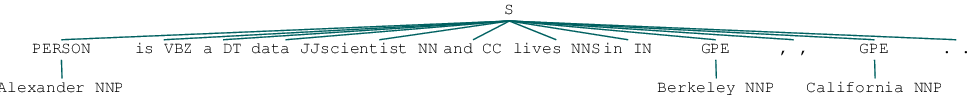

In [40]:
named_entities

#### Run named_entity_extraction 

Now let's identify and extract all named entites from the NYT corpus. This process will take a bit of time. 

In [137]:
# initiate class object
extraction_object = named_entity_extraction(topic_ids, 
                                            US_corpus)

In [138]:
start = time()
extraction_object.get_entities()
end = time()
print (  "Total run time: {:.4} minute ".format((end - start)/60)   )
print ("Each document takes about {:.4} seconds to find all entities".format((20)/US_corpus.shape[0]) )

Total run time: 17.79 minute 
Each document takes about 0.003312 seconds to find all entities


The named_entity_extraction class returns several data objects that will be very useful for the serach engine. 

**persons_topics_dict:** the count of occurances of each name entity in each topic.

**entity_count_dic:** a dict where keys are topic ids and values are sum of all entities that appear in the topic

**entity_topic_occurance:** a nested dictionary with entity as key and {topic:occurance} as the dict value

**unique_entities_dict:** a nested dictinary with topic ids as keys and {doc_j : (set of entities that appear in doc_j) } as the dict value


In [139]:
persons_topics_dict = extraction_object.get_name_entity_count(entity_type = 'persons')
entity_count_dic = extraction_object.get_entity_topic_count()
entity_topic_occurance = extraction_object.get_entity_topic_occurance()
topic_ids = extraction_object.topic_ids
unique_entities_dict = extraction_object.unique_entities_dict

The NLTK named entity chunk works well, but it's not perfect. For instance, it may miss some entities or incorrectly identify  a token as an entity. For these reasons, it is important to cross validate the performance of any chunker that we use. An example of cross validating a chunker can be found in the NLTK book [here](http://www.nltk.org/book_1ed/ch07.html). For our purposes, this is not a major concern. Our primary purpose here is to demonstrate a proof-of-concept. Improving the performance of our chunkers will be a prority in future work. 

Next, because runing the named_entity_extraction on our modestly sized corpus of ~6000 articles takes about 18 minutes, we want to save our results to file. 

#### Save entity extraction results to file

In [7]:
# with open('persons_topics_dict.pickle', 'wb') as handle:
#     pickle.dump(persons_topics_dict, handle)
    
# with open('entity_count_dic.pickle', 'wb') as handle:
#     pickle.dump(entity_count_dic, handle)
    
# with open('entity_topic_occurance.pickle', 'wb') as handle:
#     pickle.dump(entity_topic_occurance, handle)
    
# with open('topic_ids.pickle', 'wb') as handle:
#     pickle.dump(topic_ids, handle)
    
# with open('unique_entities_dict.pickle', 'wb') as handle:
#     pickle.dump(unique_entities_dict, handle)

# with open('topic_labels.pickle', 'wb') as handle:
#     pickle.dump(topic_labels, handle)

#### Load entity results data

In [2]:
with open('persons_topics_dict.pickle', 'rb') as handle:
    persons_topics_dict = pickle.load(handle)
    
with open('entity_count_dic.pickle', 'rb') as handle:
    entity_count_dic = pickle.load( handle)
    
with open('entity_topic_occurance.pickle', 'rb') as handle:
    entity_topic_occurance = pickle.load(handle)
    
with open('topic_ids.pickle', 'rb') as handle:
    topic_ids = pickle.load(handle)
    
with open('unique_entities_dict.pickle', 'rb') as handle:
    unique_entities_dict = pickle.load(handle)
    
with open('topic_labels.pickle', 'rb') as handle:
    topic_labels = pickle.load(handle)    

In [4]:
def replace_topic_names_in_dict_keys(dic, topic_label):
    for topic_label, num_label in zip(topic_labels, dic.keys()):
        dic[topic_label] = dic.pop(num_label)

    return dic

In [5]:
# run only once
unique_entities_dict =  replace_topic_names_in_dict_keys(unique_entities_dict, topic_labels)

In [6]:
unique_entities_dict.keys()

dict_keys(['justice system', 'environmental issues', 'infrastructure ', 'presidential election', 'political scandals'])

## Named Entity Searche Engine 

In [113]:
class entity_topic_occurances(object):
    
    def __init__(self, query_list, entity_topic_occurance, unique_entities_dict, topic_labels):
          
        # user's set of person entites
        self.query_list = query_list
        # dictionary of unique appearances of entites in each doc of each topic passed into dataframe
        # {entity : {topic : num_occurances } }
        self.entity_topic_occurance_df = pd.DataFrame(entity_topic_occurance).T.fillna(0)
        # topic labels named during topic modeling
        self.topic_labels = topic_labels
        # co-occurance matrix between user passed entities and topics
        self.entity_topic_co_occurance_df = self.entity_topic_occurance_df.T[self.query_list].T
        # assign topic labels as column names in dataframe
        self.entity_topic_co_occurance_df.columns = self.topic_labels
        # {topic : {doc_id : set_of_entities } }
        self.unique_entities_dict = unique_entities_dict
    
    def get_entity_topic_co_occurance(self):
        '''Returns the entity topic co-occurance dataframe'''
        return self.entity_topic_co_occurance_df
        
        
        
        
    def get_docs_with_co_occurances(self, subset_topic_labels=None):
        '''Returns list of doc ids for co-occurances of entites'''

        self.co_occurances_doc_ids = []

        if subset_topic_labels == None:
            self.topic_lables_to_search = self.topic_labels
        else:
            self.topic_lables_to_search = subset_topic_labels


        for topic_label in self.topic_lables_to_search:

            for doc_id, set_of_entities in self.unique_entities_dict[topic_label].items():

                if set_of_entities.issuperset(self.query_set ):
                    self.co_occurances_doc_ids.append(doc_id)

        return self.co_occurances_doc_ids
    
    
    def get_num_co_occurances(self,  query_set, n_entities = 2, subset_topic_labels=None):

        '''Returns nested dict of entity co-occurances in docs'''

        self.co_entity_dict = defaultdict(dict)
        

        self.query_set = query_set

        # create a set of n Choose k pairs for entities
        # create every possible pair between the entites 
        self.entity_pair_combinations = combinations( self.query_set , n_entities)

        for co_entities in self.entity_pair_combinations:

            self.entity_pairs = set(co_entities)

            # for each unique combination of entity pairs, get all doc ids in which they jointly appear
            self.co_entity_doc_ids = self.get_docs_with_co_occurances(subset_topic_labels)


            # populate nested dict for use in a co-occurance matrix 
            self.co_entity_dict[co_entities[0]][co_entities[1]] = len(self.co_entity_doc_ids)
            self.co_entity_dict[co_entities[1]][co_entities[0]] = len(self.co_entity_doc_ids)

        return self.co_entity_dict

In [114]:
# user creates a query list
query_list = ['elon musk', 'bill clinton', 'paul ryan', 'bill maher', 'bernie sanders', 'edward snowden', 'clinton', 'trump']

In [115]:
# instantiate entity_topic_occurances class
occurance_object = entity_topic_occurances(query_list, # user's named entites 
                                           entity_topic_occurance, # entity-topic-doc occurance
                                           unique_entities_dict,  # topic-doc-entity unique occurances
                                           topic_labels) # hand labled topic names

### Co-Occurance between Entities and Topics

In [116]:
entity_topic_co_occurance_df = occurance_object.entity_topic_co_occurance_df
entity_topic_co_occurance_df

,political scandals,infrastructure,justice system,presidential election,environmental issues
elon musk,0.0,0.0,0.0,1.0,2.0
bill clinton,7.0,141.0,8.0,183.0,11.0
paul ryan,0.0,80.0,5.0,9.0,6.0
bill maher,0.0,3.0,0.0,0.0,0.0
bernie sanders,0.0,62.0,4.0,65.0,14.0
edward snowden,0.0,0.0,0.0,8.0,0.0
clinton,13.0,3669.0,28.0,4567.0,313.0
trump,49.0,4486.0,10.0,1991.0,248.0


In [117]:
def plot_occurances(df, mask=None):
    '''Plot occurance matrix has heat map'''
    
    if mask:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True     
    
    # ploting entity occurance in topics
    plt.figure(figsize = (15,6))
    sns.heatmap(df, annot=True, mask=mask, fmt="g", linewidths=0.5,cmap='Blues');

/Users/Alexander/anaconda3/lib/python3.5/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/Users/Alexander/anaconda3/lib/python3.5/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


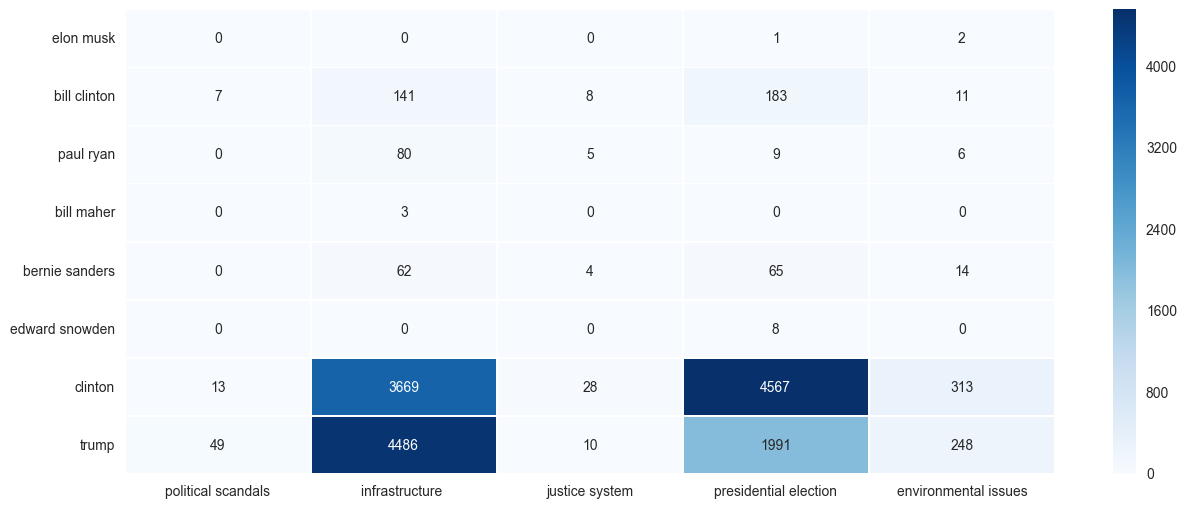

In [118]:
plot_occurances(entity_topic_co_occurance_df)

### Co-Occurances between Entities in Documents

#### Co-Occurance between Entities in Documents for Corpus

In [119]:
query_set = set(query_list)

In [147]:
# debug get_num_co_occurances output
for i in combinations(set(( 'trump', "clinton", 'paul ryan')), 2):
    print (i)

('paul ryan', 'trump')
('paul ryan', 'clinton')
('trump', 'clinton')


In [121]:
co_entity_dict = occurance_object.get_num_co_occurances(query_set=query_set)

In [132]:
# users specifices which co occurances they are interested in
query_co_occurances = set(( 'trump', "clinton", 'paul ryan'))

In [133]:
co_occur_in_docs = occurance_object.get_num_co_occurances(query_co_occurances)
co_occur_in_docs

defaultdict(dict,
            {'clinton': {'paul ryan': 51, 'trump': 51},
             'paul ryan': {'clinton': 51, 'trump': 51},
             'trump': {'clinton': 51, 'paul ryan': 51}})

/Users/Alexander/anaconda3/lib/python3.5/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/Users/Alexander/anaconda3/lib/python3.5/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


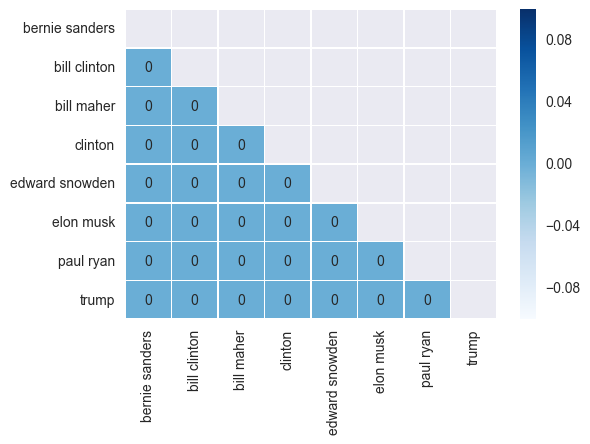

In [124]:
plot_occurances()

In [125]:
 co_entity_dict, co_entity_doc_ids_list = get_num_co_occurances(user_co_occurance_entities_set, 
                                                                unique_entities_dict, 
                                                                co_occurances_doc_ids,
                                                               1)

NameError: name 'get_num_co_occurances' is not defined

/Users/Alexander/anaconda3/lib/python3.5/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/Users/Alexander/anaconda3/lib/python3.5/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


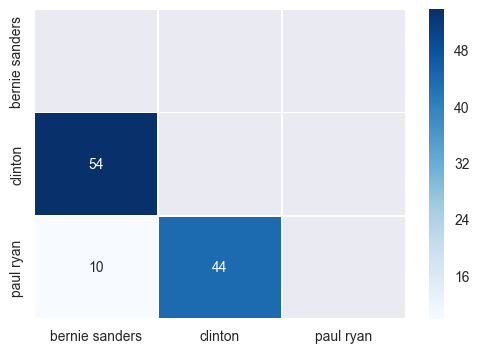

In [105]:
mask = np.zeros_like( pd.DataFrame(co_entity_dict).fillna(0), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# co-occurances of entities in docs within the corpus 
sns.heatmap(pd.DataFrame(co_entity_dict), mask=mask, annot=True, fmt="g", linewidths=0.5,cmap='Blues')

#### Ad-Hoc Queries

Find out how many documents contain all of the user's entites. 

In [71]:
 co_occurances_doc_ids = get_docs_with_co_occurances(user_co_occurance_entities_set, unique_entities_dict)

The user can now pull all the relavent documents from the corpus. 

In [72]:
# bernie and paul and clinton co-occur in all of these docs within the corpus
print(co_occurances_doc_ids[0:5]), len(co_occurances_doc_ids)

[146, 4887, 4979, 792, 4958]


(None, 9)